In [ ]:
# config = PatchTSTConfig(
#     context_length=input_length, # input 96 hours and output 48 hours
#     prediction_length=forecast_horizon,
#     patch_length=24,
#     stride=12,
#     num_input_channels=len(input_cols),  
#     target_dim=6,          
#     target_names=['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
#                   'Atmospheric Pressure', 'Wind_U', 'Wind_V'],  
#     d_model=384,
#     n_heads=16,
#     num_layers=8,
#     dropout=0.05
# )

In [4]:

from torch.utils.data import Dataset, DataLoader
from transformers import PatchTSTForPrediction, PatchTSTConfig
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib 
import matplotlib.pyplot as plt
from darts import TimeSeries
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

C:\Users\20210291\.conda\envs\torch_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Current Device Index:", torch.cuda.current_device())
else:
    print("No GPU detected.")

PyTorch version: 2.5.1
CUDA available: True
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 4080
Current Device Index: 0


In [2]:
names = ['aqaba', 'ghor', 'irbid', 'irwaished', 'maan', 'mafraq', 'amman', 'safawi']
device = "cuda" if torch.cuda.is_available() else "cpu"

In [40]:
df = pd.read_csv("Datasets-Ready/amman_Ready.csv")
df['time'] = pd.to_datetime(df['Unnamed: 0'])
df.set_index('time', inplace=True)

In [57]:
df = df[df.index.year > 2018]

In [42]:


#cyclical features
   
df['month'] = df.index.month
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Define target variables
target_cols = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
               'Atmospheric Pressure', 'Wind_U', 'Wind_V']


lag_hours = [24, 48, 168]  # 1 day, 2 days, 1 week, 2 weeks


for col in target_cols:
    for lag in lag_hours:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)
df.dropna(inplace=True)
series = TimeSeries.from_dataframe(df, value_cols=target_cols)

In [43]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [44]:
input_length = 168 
forecast_horizon = 48  
batch_size = 16
epochs = 30
learning_rate = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

#Targets and inputs
target_cols = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
               'Atmospheric Pressure', 'Wind_U', 'Wind_V']
cyclical_cols = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
lag_features = ['Air Dew Point_lag_24',
       'Air Dew Point_lag_48', 'Air Dew Point_lag_168',
       'Air Temperature (OC)_lag_24', 'Air Temperature (OC)_lag_48',
       'Air Temperature (OC)_lag_168', 'Humidity %_lag_24',
       'Humidity %_lag_48', 'Humidity %_lag_168',
       'Atmospheric Pressure_lag_24', 'Atmospheric Pressure_lag_48',
       'Atmospheric Pressure_lag_168', 'Wind_U_lag_24', 'Wind_U_lag_48',
       'Wind_U_lag_168', 'Wind_V_lag_24', 'Wind_V_lag_48', 'Wind_V_lag_168']
input_cols = target_cols + cyclical_cols + lag_features

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[input_cols])
scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=input_cols)
data_np = scaled_df.values.astype(np.float32)

Using: cuda


In [45]:
class WeatherDataset(Dataset):
    def __init__(self, data, input_len, forecast_len):
        self.data = data
        self.input_len = input_len
        self.forecast_len = forecast_len

    def __len__(self):
        return len(self.data) - self.input_len - self.forecast_len

    def __getitem__(self, idx):
        input_seq = self.data[idx : idx + self.input_len]
        target_seq = self.data[idx + self.input_len : idx + self.input_len + self.forecast_len, :6]  # only targets
        return torch.tensor(input_seq, dtype=torch.float32), torch.tensor(target_seq, dtype=torch.float32)

train_size = int(len(data_np) * 0.8)
train_data = data_np[:train_size]
val_data = data_np[train_size:]

train_dataset = WeatherDataset(train_data, input_length, forecast_horizon)
val_dataset = WeatherDataset(val_data, input_length, forecast_horizon)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [58]:
config = PatchTSTConfig(
    context_length=input_length, # input 96 hours and output 48 hours
    prediction_length=forecast_horizon,
    patch_length=48,
    stride=12,
    num_input_channels=len(input_cols),  
    target_dim=6,          
    target_names=['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
                  'Atmospheric Pressure', 'Wind_U', 'Wind_V'],  
    d_model=384,
    n_heads=16,
    num_layers=8,
    dropout=0.005
)

model = PatchTSTForPrediction(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.SmoothL1Loss()

In [47]:
@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(past_values=inputs)
        preds = outputs[0][:, :, :6]
        loss = loss_fn(preds, targets)
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [60]:
best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(past_values=inputs)
        preds = outputs[0][:, :, :6]
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)
    val_loss = evaluate(model, val_loader)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_patchtst.pt")  # Save best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch 1/30: 100%|██████████████████████████████████████████████████████████████████| 2608/2608 [03:40<00:00, 11.82it/s]


Epoch 1 | Train Loss: 0.2107 | Val Loss: 0.1708


Epoch 2/30: 100%|██████████████████████████████████████████████████████████████████| 2608/2608 [03:40<00:00, 11.82it/s]


Epoch 2 | Train Loss: 0.1804 | Val Loss: 0.1666


Epoch 3/30: 100%|██████████████████████████████████████████████████████████████████| 2608/2608 [03:40<00:00, 11.82it/s]


Epoch 3 | Train Loss: 0.1746 | Val Loss: 0.1646


Epoch 4/30:  79%|████████████████████████████████████████████████████▎             | 2069/2608 [02:55<00:45, 11.79it/s]


KeyboardInterrupt: 

In [22]:
print(inputs.shape)

torch.Size([16, 168, 28])


C:\Users\20210291\AppData\Local\Temp\ipykernel_33600\2116807709.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_patchtst.pt", map

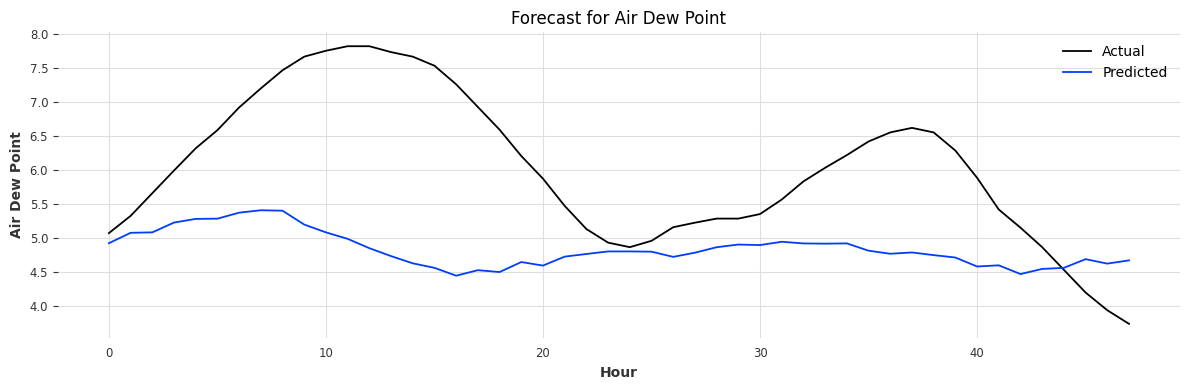

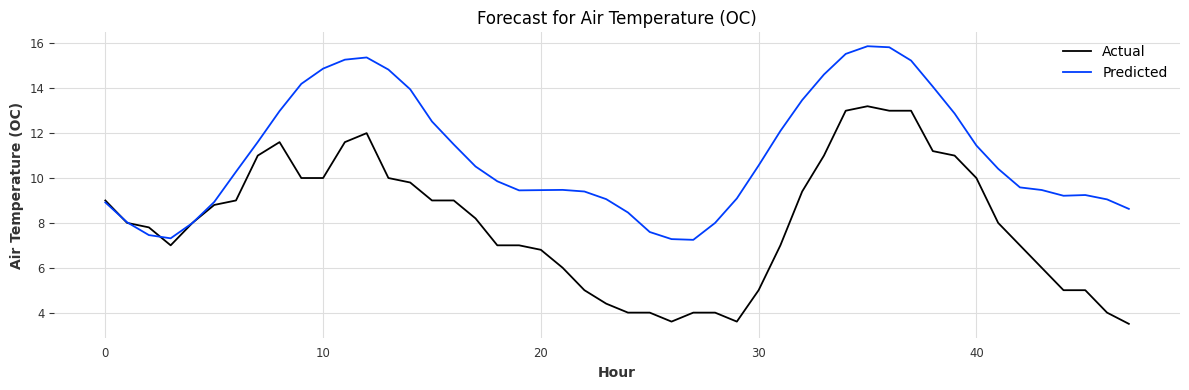

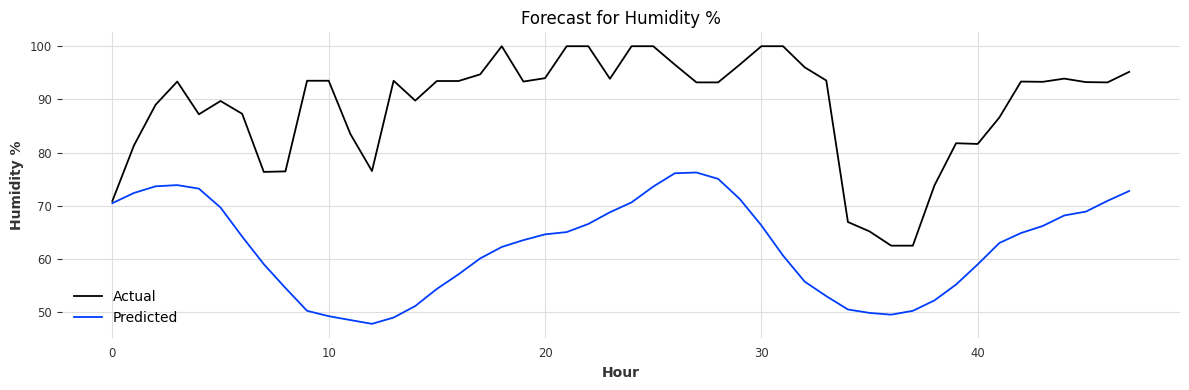

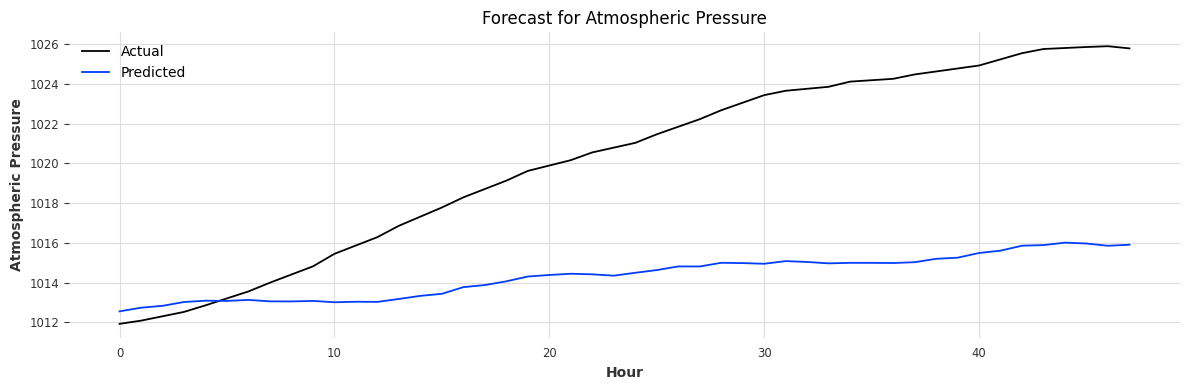

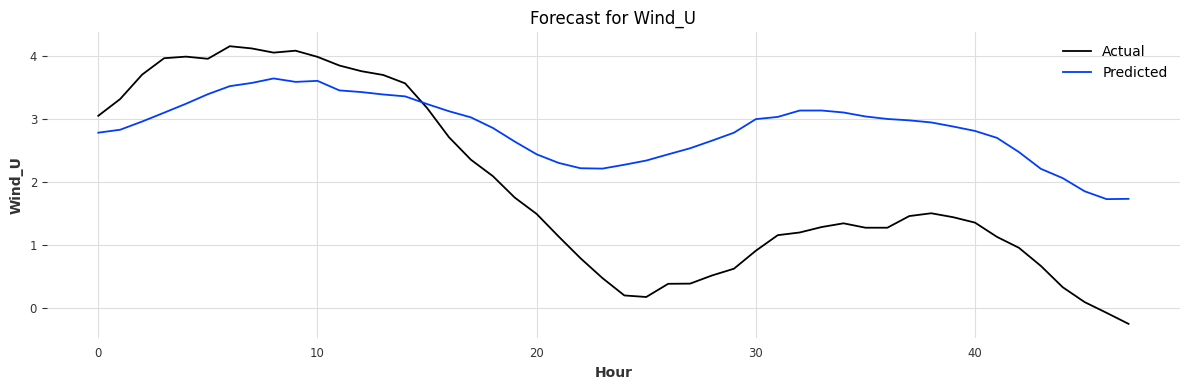

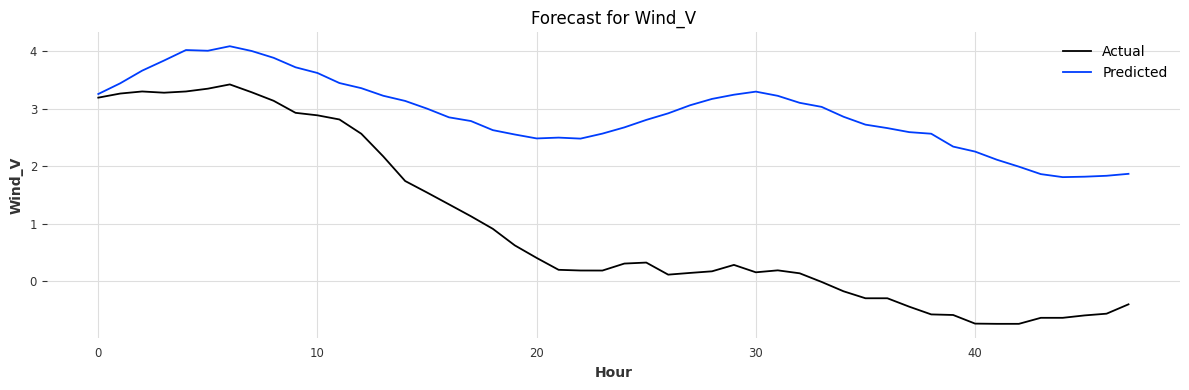

In [61]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
from transformers import PatchTSTForPrediction

# ---------- 1. Load & Preprocess Test Data ----------
test_df = pd.read_csv("Amman_test_data/amman_test.csv")
test_df['time'] = pd.to_datetime(test_df['Unnamed: 0'])
test_df.set_index('time', inplace=True)

# Recreate cyclical features
test_df['month'] = test_df.index.month
test_df['hour'] = test_df.index.hour
test_df['dayofweek'] = test_df.index.dayofweek
test_df['hour_sin'] = np.sin(2 * np.pi * test_df['hour'] / 24)
test_df['hour_cos'] = np.cos(2 * np.pi * test_df['hour'] / 24)
test_df['month_sin'] = np.sin(2 * np.pi * test_df['month'] / 12)
test_df['month_cos'] = np.cos(2 * np.pi * test_df['month'] / 12)

# Define columns
target_cols = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
               'Atmospheric Pressure', 'Wind_U', 'Wind_V']
cyclical_cols = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
lag_features = [f'{col}_lag_{lag}' for col in target_cols for lag in [24, 48, 168]]
input_cols = target_cols + cyclical_cols + lag_features

# Add lag features
for col in target_cols:
    for lag in [24, 48, 168]:
        test_df[f'{col}_lag_{lag}'] = test_df[col].shift(lag)

test_df.dropna(inplace=True)

# Scale using the same scaler as training
scaled_test_data = scaler.transform(test_df[input_cols])
scaled_test_df = pd.DataFrame(scaled_test_data, columns=input_cols, index=test_df.index)

# ---------- 2. Prepare Dataset ----------
class WeatherDataset(Dataset):
    def __init__(self, data, input_len, forecast_len):
        self.data = data
        self.input_len = input_len
        self.forecast_len = forecast_len

    def __len__(self):
        return len(self.data) - self.input_len - self.forecast_len

    def __getitem__(self, idx):
        input_seq = self.data[idx : idx + self.input_len]
        target_seq = self.data[idx + self.input_len : idx + self.input_len + self.forecast_len, :6]
        return torch.tensor(input_seq, dtype=torch.float32), torch.tensor(target_seq, dtype=torch.float32)

test_dataset = WeatherDataset(scaled_test_df.values.astype(np.float32), 168, 48)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# ---------- 3. Load Model ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("best_patchtst.pt", map_location=device))
model.to(device)
model.eval()

# ---------- 4. Predict ----------
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(past_values=inputs)
        preds = outputs[0][:, :, :6].cpu().numpy()
        predictions.append(preds[0])
        actuals.append(targets[0].numpy())

predictions = np.array(predictions)  # shape: (N, 48, 6)
actuals = np.array(actuals)

# ---------- 5. Inverse Scale ----------
# Only inverse transform the 6 target columns
target_scaler = StandardScaler()
target_scaler.mean_ = scaler.mean_[:6]
target_scaler.scale_ = scaler.scale_[:6]

predictions_unscaled = target_scaler.inverse_transform(predictions.reshape(-1, 6)).reshape(predictions.shape)
actuals_unscaled = target_scaler.inverse_transform(actuals.reshape(-1, 6)).reshape(actuals.shape)

# ---------- 6. Plot ----------
import matplotlib.pyplot as plt

var_names = target_cols
n_vars = len(var_names)

for i in range(n_vars):
    plt.figure(figsize=(12, 4))
    plt.plot(actuals_unscaled[0, :, i], label='Actual')
    plt.plot(predictions_unscaled[0, :, i], label='Predicted')
    plt.title(f'Forecast for {var_names[i]}')
    plt.xlabel('Hour')
    plt.ylabel(var_names[i])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
